# **Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook**
---



>[Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook](#scrollTo=Ko-3w5ahytsa&uniqifier=1)

>[1-Importing necessary packages](#scrollTo=GzhjArf-EmPg&uniqifier=1)

>[2-Importing the different datasets with distinct input features (PCA, RMSD, and extra)](#scrollTo=ymzrM00AEzmf&uniqifier=1)

>[3-Allocating Key-Value Pairs from Mat Data to Tensors](#scrollTo=Tc_M-3S0FRNm&uniqifier=1)

>[4-One-Hot Encoding of Training, Validation, and Test Datasets](#scrollTo=qO4SCOx3HbIf&uniqifier=1)

>[5-Separating Data for Classification and Regression Loss](#scrollTo=G_IL7DDSSOOS&uniqifier=1)

>>[normalizing CNN inputs](#scrollTo=7_Ciynysr-fA&uniqifier=1)

>[Defining ML model using functional API](#scrollTo=U8fmjmzfr8iv&uniqifier=1)

>>[Defining the model](#scrollTo=LAixckJV1o8n&uniqifier=1)

>>>[Defining the model architecture](#scrollTo=sYHQOQaku3ZQ&uniqifier=1)

>[Evaluate the model using Learning Curve](#scrollTo=toTOorbsJavR&uniqifier=1)



# 1-Importing necessary packages



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,Concatenate
from tensorflow.keras.layers import LeakyReLU,Flatten,GlobalAveragePooling2D
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
from tensorflow.keras.activations import relu,linear

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

# !pip install -Uqq ipdb
# import ipdb


In [ ]:
!pip install -Uqq ipdb
import ipdb
if tf.test.gpu_device_name():
  print('GPU is available')
  print(tf.config.list_physical_devices('GPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00


# 2-Importing the different datasets with distinct input features (PCA, RMSD, and extra)
In this section of the Python notebook, we will import various datasets that contain different sets of input features. These features include PCA (Principal Component Analysis), RMSD (Root Mean Square Deviation), and additional features.

In [ ]:
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/EMI-data/CNNdataset.mat'
data = scipy.io.loadmat(mat_file_path)

Mounted at /content/drive


In [ ]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'OutputTrain', 'inputTrain', 'OutputVal', 'inputVal'])


# 3-Allocating Key-Value Pairs from Mat Data to Tensors
In this section, we will focus on allocating key-value pairs from a Mat data file to tensors. The Mat file contains structured data with keys representing different features or variables, and values containing the corresponding data arrays. Our goal is to efficiently extract this data and convert it into tensor format, which is commonly used in deep learning frameworks like TensorFlow.

In [ ]:
# input_Test=tf.convert_to_tensor(data['inputTest'])
input_Val=tf.convert_to_tensor(data['inputVal'])
input_train=tf.convert_to_tensor(data['inputTrain'])
# output_Test=tf.convert_to_tensor(data['OutputTest'])
output_Val=tf.convert_to_tensor(data['OutputVal'])
output_train=tf.convert_to_tensor(data['OutputTrain'])


In [ ]:
input_train.shape

TensorShape([3441, 4, 10486])

# 4-One-Hot Encoding of Training, Validation, and Test Datasets
In this section of the notebook, we will perform one-hot encoding on the training, validation, and test datasets. One-hot encoding is a common technique used to transform categorical variables into a binary representation that can be effectively used by machine learning algorithms.
By applying one-hot encoding, we will convert categorical variables in our datasets into binary columns, where each column represents a unique category. This transformation enables us to incorporate categorical information into our models accurately and efficiently.

In [ ]:
# One hot encoding of train, val and test dataset

regions=tf.gather(output_train,1,axis=1)
regions2=tf.gather(output_Val,1,axis=1)
# regions3=tf.gather(output_Test,1,axis=1)
# pd.DataFrame(regions)
regions=tf.one_hot(regions,depth=4,axis=0)
regions2=tf.one_hot(regions2,depth=4,axis=0)
# regions3=tf.one_hot(regions3,depth=4,axis=0)
regions=tf.transpose(regions)
regions2=tf.transpose(regions2)
# regions3=tf.transpose(regions3)
# pd.DataFrame(regions)
# output_Val
# output_Test

# 5-Separating Data for Classification and Regression Loss
In this section, we will split our dataset into two subsets: one for classification tasks and the other for regression tasks. This separation is crucial as different machine learning models and loss functions are often employed for these distinct problem types.

In [ ]:
# output_reg=output_train[:,[1,2]]
# output_reg = tf.gather(output_train, [1, 2], axis=1)
# output_log = tf.gather(output_train, 0, axis=1)
sever=tf.gather(output_train,0,axis=1)
sever = tf.cast(sever, dtype=tf.float32)
sever=tf.reshape(sever, shape=(-1, 1))
output_reg=tf.concat([sever,regions],axis=1)
# pd.DataFrame(output_reg)

sever=tf.gather(output_Val,0,axis=1)
sever = tf.cast(sever, dtype=tf.float32)
sever=tf.reshape(sever, shape=(-1, 1))
output_regVal=tf.concat([sever,regions2],axis=1)
# pd.DataFrame(output_regVal)
# pd.DataFrame(output_reg)
# output_regVal = tf.gather(output_Val, [1, 2], axis=1)
# output_logVal = tf.gather(output_Val, 0, axis=1)

In [ ]:
seed = 42
tf.random.set_seed(seed)

# # Shuffle the data tensors together
indices = tf.range(start=0, limit=tf.shape(input_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed=seed)
input_train = tf.gather(input_train, shuffled_indices)
output_reg = tf.gather(output_reg, shuffled_indices)
# # output_log = tf.gather(output_log, shuffled_indices)

unshuffled_input=input_Val
indices = tf.range(start=0, limit=tf.shape(unshuffled_input)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed=seed)
input_Val = tf.gather(unshuffled_input, shuffled_indices)
output_regVal = tf.gather(output_regVal, shuffled_indices)

In [ ]:
output_sev_val=tf.gather(output_regVal,0 ,axis=1)
output_label_val=tf.gather(output_regVal,range(1,output_reg.shape[1]),axis=1)

output_sev=tf.gather(output_reg,0 ,axis=1)
output_label=tf.gather(output_reg,range(1,output_reg.shape[1]),axis=1)
# pd.DataFrame(output_label_val)
# pd.DataFrame(output_sev_val)
# output_logVal = tf.gather(output_logVal, shuffled_indices)

In [ ]:
print(shuffled_indices[0])
print(input_Val.shape)
pd.DataFrame(shuffled_indices)

tf.Tensor(692, shape=(), dtype=int32)
(776, 4, 10486)


,0
0,692
1,426
2,353
3,228
4,373
...,...
771,6
772,256
773,189
774,457


In [ ]:
print(list(range(1,output_reg.shape[1])))
pd.DataFrame(input_Val[:,2,:])


[1, 2, 3, 4]


,0,1,2,3,4,5,6,7,8,9,...,10476,10477,10478,10479,10480,10481,10482,10483,10484,10485
0,0.007393,0.007550,0.007687,0.007796,0.007871,0.007908,0.007908,0.007874,0.007812,0.007728,...,0.049341,0.049424,0.049469,0.049482,0.049471,0.049448,0.049421,0.049402,0.049397,0.049414
1,0.007810,0.007799,0.007723,0.007585,0.007395,0.007172,0.006936,0.006712,0.006522,0.006389,...,0.058721,0.058718,0.058702,0.058683,0.058671,0.058675,0.058703,0.058760,0.058849,0.058969
2,0.006869,0.007087,0.007328,0.007580,0.007829,0.008060,0.008262,0.008425,0.008540,0.008603,...,0.045276,0.045400,0.045550,0.045719,0.045898,0.046075,0.046240,0.046381,0.046491,0.046564
3,0.007688,0.007668,0.007569,0.007396,0.007162,0.006884,0.006584,0.006288,0.006020,0.005803,...,0.046458,0.046578,0.046740,0.046938,0.047165,0.047411,0.047662,0.047906,0.048130,0.048321
4,0.006786,0.006990,0.007214,0.007446,0.007674,0.007884,0.008068,0.008215,0.008320,0.008380,...,0.044796,0.044997,0.045230,0.045485,0.045749,0.046008,0.046247,0.046453,0.046614,0.046725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0.005942,0.006196,0.006418,0.006579,0.006659,0.006648,0.006545,0.006357,0.006101,0.005800,...,0.042166,0.042206,0.042251,0.042298,0.042344,0.042388,0.042427,0.042462,0.042495,0.042529
772,0.007587,0.007561,0.007460,0.007288,0.007055,0.006779,0.006479,0.006181,0.005906,0.005680,...,0.045842,0.045960,0.046129,0.046344,0.046598,0.046877,0.047169,0.047456,0.047723,0.047958
773,0.007467,0.007512,0.007506,0.007437,0.007302,0.007104,0.006854,0.006569,0.006271,0.005983,...,0.046322,0.046499,0.046707,0.046935,0.047172,0.047405,0.047620,0.047807,0.047956,0.048063
774,0.007421,0.007416,0.007352,0.007231,0.007061,0.006860,0.006646,0.006443,0.006273,0.006154,...,0.054551,0.054553,0.054557,0.054572,0.054609,0.054673,0.054770,0.054903,0.055069,0.055266


In [ ]:
pd.DataFrame(unshuffled_input[692,2,:])

,0
0,0.007393
1,0.007550
2,0.007687
3,0.007796
4,0.007871
...,...
10481,0.049448
10482,0.049421
10483,0.049402
10484,0.049397


## normalizing CNN inputs
For normalizing CNN inputs, mean-centering is applied to raw data. This retains varying variances, enhancing sensitivity to significant changes without normalizing variance.

In [ ]:
def mean_center(tensor):
    # Calculate the mean along the first axis (rows)
    mean = tf.reduce_mean(tensor, axis=0, keepdims=True)

    # Subtract the mean from the tensor
    centered_tensor = tensor - mean

    return centered_tensor


In [ ]:
# Example usage mean center
# data = tf.constant([[[1.0, 2.5, 3.0], [4.0, 5.0, 6.0]],
#                     [[7.0, 8.0, 9.0], [10.0, 11.0, 12.0]],
#                     [[13.0, 14.0, 15.0], [16.0, 17.0, 18.0]]], dtype=tf.float32)

# centered_data = mean_center(data)
# print(centered_data.numpy())
# print(data.numpy)

In [ ]:
inptest=input_train
input_train=mean_center(input_train)
input_Val=mean_center(input_Val)

In [ ]:
#testing the function and input data
mean = tf.reduce_mean(inptest[:,2,1000], axis=0, keepdims=True)
print((inptest[20,2,1000]-mean))
pd.DataFrame(input_train[:,3,:]*1000)

tf.Tensor([-0.00025764], shape=(1,), dtype=float64)


,0,1,2,3,4,5,6,7,8,9,...,10476,10477,10478,10479,10480,10481,10482,10483,10484,10485
0,1.416632,0.513486,-0.278371,-0.913881,-1.360156,-1.598923,-1.628250,-1.463214,-1.135130,-0.689149,...,-2.967817,-3.004163,-2.933027,-2.763433,-2.511626,-2.199806,-1.854408,-1.504085,-1.177576,-0.901586
1,2.064972,0.999026,0.070384,-0.673226,-1.199028,-1.491116,-1.551593,-1.400567,-1.074705,-0.624128,...,-3.030223,-3.049578,-2.936596,-2.701530,-2.363203,-1.947585,-1.485902,-1.012361,-0.561722,-0.166847
2,2.943065,1.470574,0.171353,-0.892322,-1.676036,-2.155640,-2.328952,-2.216356,-1.859805,-1.319878,...,-3.601068,-3.632209,-3.543699,-3.341218,-3.038095,-2.654369,-2.215388,-1.750092,-1.289085,-0.862635
3,0.986908,0.146039,-0.539457,-1.038167,-1.332429,-1.419677,-1.312969,-1.040356,-0.642856,-0.170937,...,-2.234035,-2.295504,-2.276695,-2.183364,-2.026772,-1.822810,-1.590799,-1.352022,-1.128186,-0.939841
4,-2.325625,-1.020794,0.085176,0.934039,1.488087,1.732780,1.678123,1.358319,0.829265,0.163785,...,4.241954,4.260347,4.129937,3.863367,3.483212,3.020220,2.510932,1.994872,1.511599,1.097751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,2.248028,1.177584,0.244269,-0.503706,-1.033308,-1.328543,-1.391550,-1.242556,-0.918397,-0.469410,...,-2.733880,-2.749308,-2.641058,-2.419119,-2.102000,-1.715257,-1.289549,-0.858276,-0.455075,-0.111281
3437,-1.445670,0.005086,1.196985,2.073281,2.600809,2.772325,2.607364,2.151137,1.471135,0.651428,...,4.167854,4.325301,4.316704,4.146772,3.831512,3.396944,2.877106,2.311488,1.742146,1.210679
3438,-2.443164,-1.210793,-0.181142,0.603156,1.117125,1.354830,1.329910,1.074916,0.639139,0.084775,...,3.910462,3.797260,3.598919,3.334804,3.027493,2.700952,2.378703,2.082148,1.829162,1.632978
3439,1.387230,0.501505,-0.275182,-0.897887,-1.333745,-1.564439,-1.587949,-1.419208,-1.089332,-0.643210,...,-3.182759,-3.151673,-3.009269,-2.767784,-2.446847,-2.072058,-1.673131,-1.281692,-0.928984,-0.643558


Based on prior findings, it is recommended to scale the training data by a factor of 1000 to achieve a range approximately between -1 and 1 for improved model training.

To balance optimization across all tasks and prevent the regression output from dominating the total loss function, the regression output should be normalized, considering the classification outputs have a range of 0-1.


In [ ]:
input_Val=input_Val*1000
input_train=input_train*1000
input_Val=tf.expand_dims(input_Val,-1)
input_train=tf.expand_dims(input_train,-1)
# Calculate the mean and standard deviation of the training targets
mean_y_train = tf.reduce_mean(output_reg)
std_y_train = tf.math.reduce_std(output_reg)

# Normalize the targets by subtracting the mean and dividing by the standard deviation
output_reg = (output_reg - mean_y_train) / std_y_train
output_regVal = (output_regVal - mean_y_train) / std_y_train

In [ ]:
b=tf.expand_dims(input_train,-1)
a=b.shape[1:]
print(type(a))
c=tuple(a)
print(type(c))

<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tuple'>


# Defining ML model using functional API

Definnig a untility fuction to apply convolution operation followed by batch normalization and an activation layer
if alpha has value the activation fuction will be LeakyRelu with the specified alpha

In [ ]:
def convbatch(inp,filters,kernel_size,strides,padding='valid',
                     activation='linear',alpha=0.0,bn=True,scale=True,name=None):

  #Args= bn: batch normalization
  #      alpha= alpha coefficient in leaky relu activation fuction
  #      activation= a string or object for activation in tensorflow
  conv1=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding,name=name)(inp)
  if bn:
    conv1=BatchNormalization(axis=3,scale=scale)(conv1)


  if alpha==0.0:
    out=Activation(activation)(conv1)
  else:
      out=LeakyReLU(alpha=alpha)(conv1)
  return out


##Defining the model

In [ ]:
def base_model(input_layer):
#---------------------------------------------------------------------------------
#                               BLOCK 1
#---------------------------------------------------------------------------------
  hidden1_B1=convbatch(input_layer,4,(1,10),strides=(1,1),padding='same',
                       bn=False,name='Block1_conv1')

  hidden2_B1=convbatch(input_layer,1,(4,10),strides=(1,1),padding='same',
                       name='Block1_conv2',bn=False)

  hidden=Concatenate(axis=-1)([hidden1_B1,hidden2_B1,input_layer])
  block1=MaxPooling2D((1,10),strides=(1,10))(hidden)

#---------------------------------------------------------------------------------
#                               BLOCK 2
#---------------------------------------------------------------------------------
  hidden1_B2=convbatch(block1,15,(1,3),strides=(1,1),padding='same',
                    activation='tanh',name='Block2_conv1')
  hidden1_B2=convbatch(hidden1_B2,5,(1,1),strides=(1,1),padding='same',
                    activation='tanh',name='Block2_conv1-2')

  hidden2_B2=convbatch(block1,5,(1,5),strides=(1,1),padding='same',
                    activation='tanh',name='Block2_conv2')

  hidden3_B2=convbatch(block1,2,(2,3),strides=(1,1),padding='same',
                    activation='tanh',name='Block2_conv3')

  hidden=Concatenate(axis=-1)([hidden1_B2,hidden2_B2,hidden3_B2])
  block2=MaxPooling2D((1,5),strides=(1,3))(hidden)
#---------------------------------------------------------------------------------
#                               BLOCK 3
#---------------------------------------------------------------------------------
  # hidden1_reg_B3=convbatch(block2,5,(1,1),strides=(1,1),padding='same',
  #                   activation='relu',scale=False,name='Block3_conv1-3')
  # hidden1_B3=convbatch(hidden1_reg_B3,10,(1,3),strides=(1,1),padding='same',
  #                   activation='relu',scale=False,name='Block3_conv1')
  # # hidden1_B3=convbatch(hidden1_B3,5,(1,1),strides=(1,1),padding='same',
  # #                   activation='relu',scale=False,name='Block3_conv1-2')

  # hidden1_reg_B3=convbatch(block2,5,(1,1),strides=(1,1),padding='same',
  #                   activation='relu',scale=False,name='Block3_conv2-3')
  # hidden2_B3=convbatch(hidden1_reg_B3,10,(1,5),strides=(1,1),padding='same',
  #                   activation='relu',scale=False,name='Block3_conv2')


  # hidden=Concatenate(axis=-1)([hidden1_B3,hidden2_B3])

  # block3=MaxPooling2D((1,3),strides=(1,2))(hidden)

#---------------------------------------------------------------------------------
#                               BLOCK 4
#---------------------------------------------------------------------------------
  hidden_Reg_B4=convbatch(block2,10,(1,1),strides=(1,1),padding='same',
                    alpha=0.3,name='Block4_reg_conv1')
  hidden=MaxPooling2D((1,3),strides=(1,2))(hidden_Reg_B4)

  hidden1_B4=convbatch(hidden,15,(1,3),strides=(1,2),padding='valid',
                    alpha=0.3,name='Block4_conv1')
  block4=MaxPooling2D((1,3),strides=(1,2))(hidden1_B4)

  # hidden_Reg_B4=convbatch(block4,15,(1,1),strides=(1,1),padding='same',
  #                   alpha=0.3,name='Block4_reg2_conv2')
  # hidden=MaxPooling2D((1,3),strides=(1,2))(hidden_Reg_B4)

  # hidden_Reg_B4=convbatch(hidden,20,(1,3),strides=(1,2),padding='same',
  #                   activation='relu',name='Block4_reg2_conv3')

  # hidden1_B4=convbatch(hidden,15,(1,3),strides=(1,2),padding='valid',
  #                   activation='relu',scale=False,name='Block4_conv2')
  # block4=MaxPooling2D((1,3),strides=(1,2))(hidden1_B4)

  # hidden2_B4=convbatch(block4,15,(1,3),strides=(1,2),padding='valid',
  #                   activation='relu',scale=False,name='Block4_conv3')

  # block4=MaxPooling2D((1,3),strides=(1,2))(hidden2_B4)

#---------------------------------------------------------------------------------
#                               BLOCK 5
#---------------------------------------------------------------------------------
  # hidden1_B5=convbatch(block4,20,(1,3),strides=(1,2),padding='valid',
  #                   activation='relu',scale=False,name='Block5_conv1')
  # block5=MaxPooling2D((3,3),strides=(1,2))(hidden1_B5)

#---------------------------------------------------------------------------------
#                               BLOCK 6
#---------------------------------------------------------------------------------
  # hidden1_B6=convbatch(block5,20,(1,3),strides=(1,2),padding='same',
  #                   activation='relu',scale=False,name='Block6_conv1')
  block6=GlobalAveragePooling2D(data_format='channels_last')(block4)

  return block6


In [ ]:
print(tuple(input_train.shape[0:]))

(3441, 4, 10486, 1)


In [ ]:
#Test
# input_layer = Input(shape=(tuple(input_train.shape[1:])))
# hidden=base_model(input_layer)
# hidden=Flatten()(hidden)
# out=Dense(2)(hidden)
# model=tf.keras.models.Model(inputs=input_layer,outputs=out)

###Defining the model architecture

In [ ]:

input_layer = Input(shape=(tuple(input_train.shape[1:])))
hidden=base_model(input_layer)
hidden=Flatten()(hidden)
hidden=Dropout(0.4)(hidden)
# output design
outLabel =Dense(4, name='outLabel',activation='softmax')(hidden)
outSev =Dense(1, name='outSev')(hidden)

# Create the model with two outputs
model = tf.keras.models.Model(inputs=input_layer, outputs=[outSev,outLabel])

# Define the loss functions for each output

losses = {
    'outSev': 'mean_squared_error',
    'outLabel' : 'categorical_crossentropy'

}

metrics = {
    'outSev': [tf.keras.metrics.RootMeanSquaredError()],
    'outLabel' : 'accuracy'
}

opt=tf.optimizers.experimental.RMSprop()
# Compiling the model with multiple losses and loss weights
LossWeights={'outSev':0.05,
             'outLabel':0.95}

# model.compile(optimizer=opt, loss=losses,metrics=metrics)
model.compile(optimizer=opt, loss=losses,loss_weights=LossWeights,metrics=metrics)
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 10486, 1  0           []                               
                                )]                                                                
                                                                                                  
 Block1_conv1 (Conv2D)          (None, 4, 10486, 4)  44          ['input_1[0][0]']                
                                                                                                  
 Block1_conv2 (Conv2D)          (None, 4, 10486, 1)  41          ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 4, 10486, 4)  0           ['Block1_conv1[0][0]']       

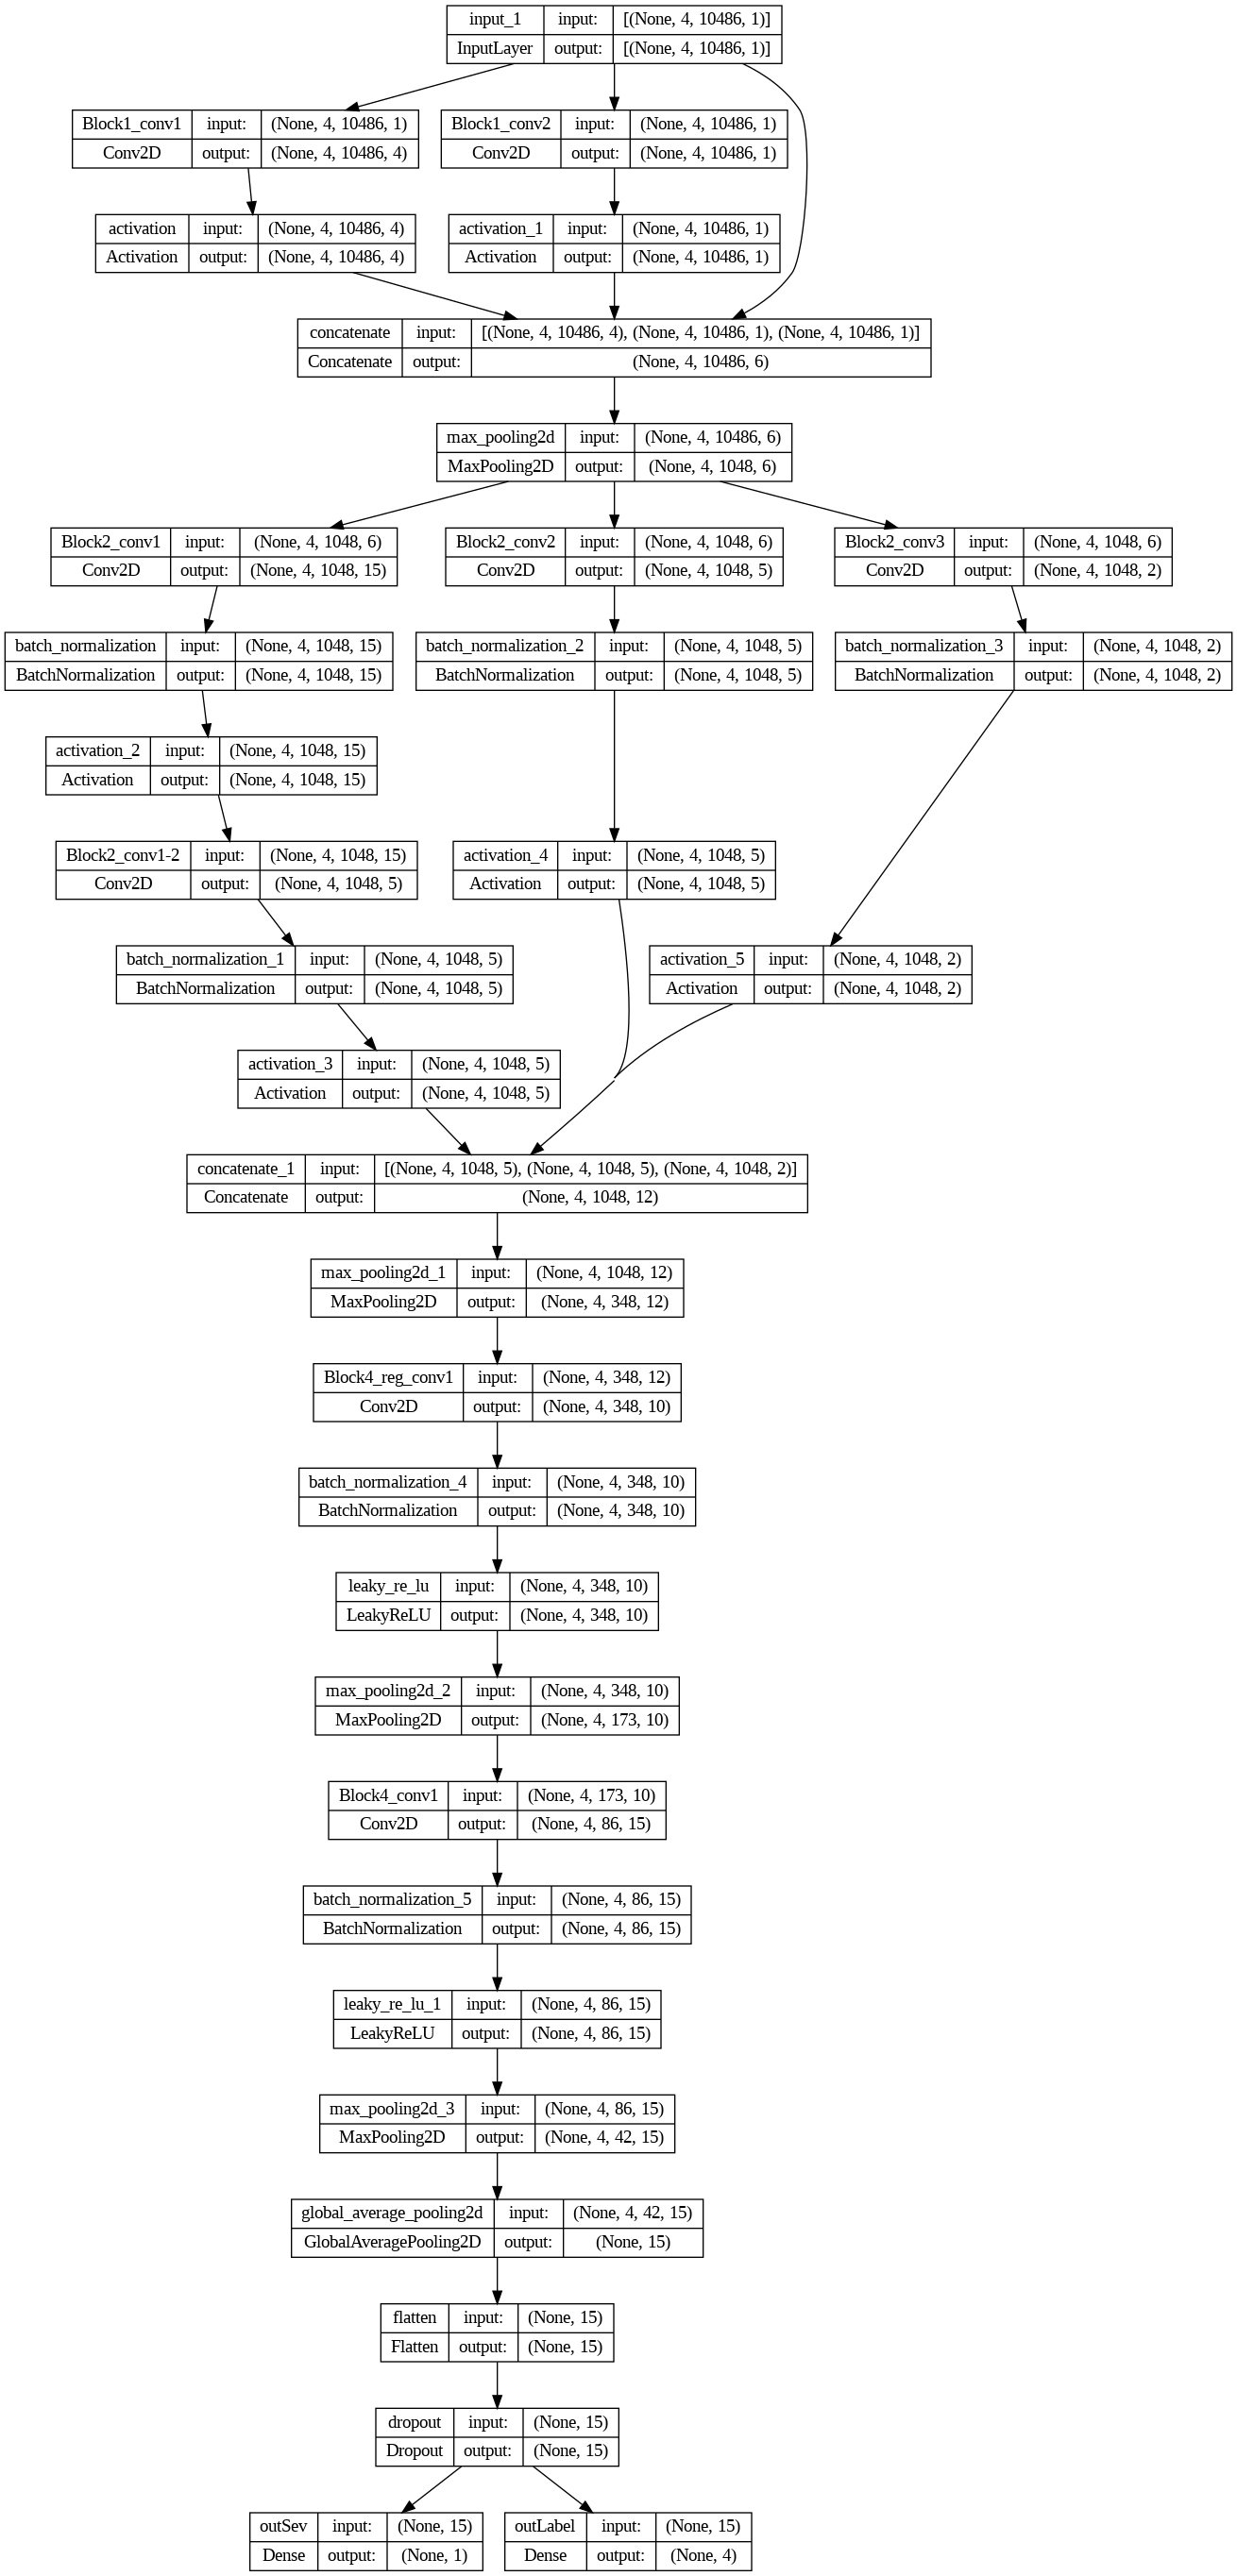

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:

opt2=tf.optimizers.experimental.RMSprop(0.0002)
model.compile(optimizer=opt2, loss=losses,loss_weights=LossWeights,metrics=metrics)
pd.DataFrame(model.get_compile_config())

,optimizer,loss,metrics,loss_weights,weighted_metrics,run_eagerly,steps_per_execution,jit_compile
module,keras.optimizers.experimental,NaN,NaN,NaN,None,None,None,None
class_name,RMSprop,NaN,NaN,NaN,None,None,None,None
config,"{'name': 'RMSprop', 'weight_decay': None, 'cli...",NaN,NaN,NaN,None,None,None,None
registered_name,None,NaN,NaN,NaN,None,None,None,None
outSev,NaN,mean_squared_error,"[{'module': 'keras.metrics', 'class_name': 'Ro...",0.05,None,None,None,None
outLabel,NaN,categorical_crossentropy,accuracy,0.95,None,None,None,None


In [ ]:
history=model.fit(input_train,[output_sev,output_label],
                  validation_data=(input_Val,[output_sev_val,output_label_val]),
                  epochs=50, batch_size=64)

Epoch 1/50
54/54 [==============================] - 8s 49ms/step - loss: 2.2333 - outSev_loss: 16.3197 - outLabel_loss: 1.4919 - outSev_root_mean_squared_error: 4.0398 - outLabel_accuracy: 0.3229 - val_loss: 2.1448 - val_outSev_loss: 16.3591 - val_outLabel_loss: 1.3967 - val_outSev_root_mean_squared_error: 4.0446 - val_outLabel_accuracy: 0.2410
Epoch 2/50
54/54 [==============================] - 2s 39ms/step - loss: 1.6259 - outSev_loss: 8.4105 - outLabel_loss: 1.2688 - outSev_root_mean_squared_error: 2.9001 - outLabel_accuracy: 0.4016 - val_loss: 1.9227 - val_outSev_loss: 14.9910 - val_outLabel_loss: 1.2349 - val_outSev_root_mean_squared_error: 3.8718 - val_outLabel_accuracy: 0.2577
Epoch 3/50
54/54 [==============================] - 2s 46ms/step - loss: 1.3898 - outSev_loss: 4.8542 - outLabel_loss: 1.2074 - outSev_root_mean_squared_error: 2.2032 - outLabel_accuracy: 0.4188 - val_loss: 1.6001 - val_outSev_loss: 10.4395 - val_outLabel_loss: 1.1349 - val_outSev_root_mean_squared_error: 

#Evaluate the model using Learning Curve
In this section of the notebook, we will plot the learning curve to visualize the performance of our model as the training data size increases. The learning curve provides valuable insights into how well our model generalizes and whether it is underfitting or overfitting.

First we implementing learning plot.

In [ ]:
def LC_plt(train,val, StartPoint=1):
  # Get the training and validation loss from the history object
  # Get the training and validation loss from the 50th epoch onwards
  training_loss = train[StartPoint:]  # Adjust index based on 0-indexing
  validation_loss = val[StartPoint:]  # Adjust index based on 0-indexing

  # Plot the learning curve
  epochs = range(StartPoint, len(training_loss) + StartPoint)  # Adjust the starting epoch
  plt.plot(epochs, training_loss, 'r', label='Training Loss')
  plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [ ]:
losses_outlabel_train=history.history['outLabel_loss']
losses_outlabel_val=history.history['val_outLabel_loss']

losses_outsev_train=history.history['outSev_loss']
losses_outsev_val=history.history['val_outSev_loss']

losses__train=history.history['loss']
losses_val=history.history['val_loss']

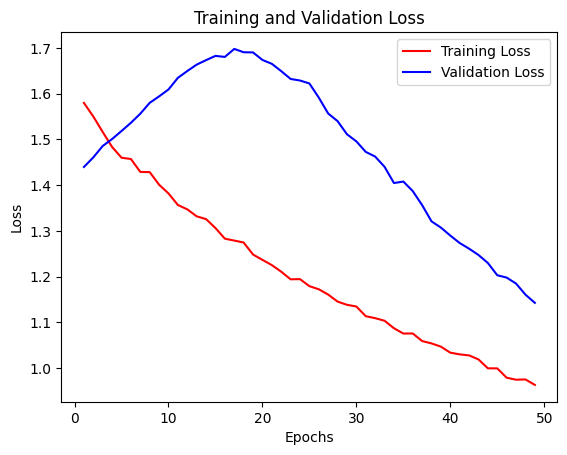

In [ ]:
LC_plt(losses_outlabel_train,losses_outlabel_val,StartPoint=1)

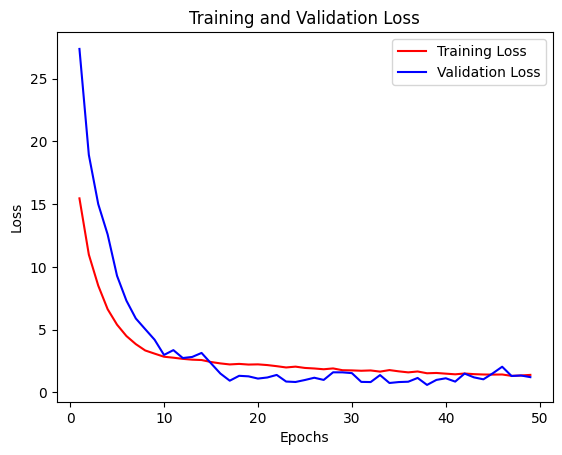

In [ ]:
LC_plt(losses_outsev_train,losses_outsev_val,StartPoint=1)

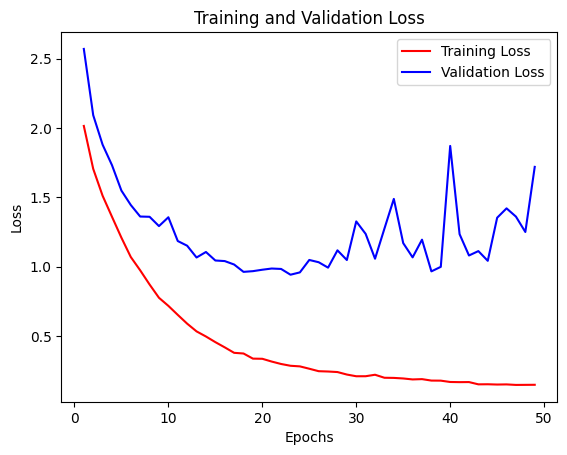

In [ ]:
LC_plt(losses__train,losses_val,StartPoint=1)

In [ ]:
!pip3 show tf.keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow
